In [227]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import random_split
from sklearn.metrics import root_mean_squared_error

np.random.seed(0)

In [228]:
#Class: RNN
class RNN(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
    
    #Input must be torch.Tensor and normalized
    def forward(self, input):
        #h0 = self.initHidden()
        h_list, hn = self.i2h(input)
        output_list = self.h2o(h_list)
        return output_list

In [229]:
#Class : LSTM
class LSTM(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)

    
    #Input must be torch.Tensor and normalized
    def forward(self, input):
        h_list, (hn,cn) = self.i2h(input)
        output_list = self.h2o(h_list)
        return output_list

In [230]:
#Parameters to get several scenari
CSV_FILE = "C:/Users/Utilisateur/Documents/ENSAE/Stage/simulation/simulation.csv"
TRAINING_NUMBER = 400
USE_NOISY_DATA = True
USE_MIXED_EFFECT = False
timestep_skip = 1
MODEL = LSTM

In [231]:
#data loading
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")

In [232]:
x_labels = [
    c for c in data.columns if c.startswith("x") and (("_obs" in c) is USE_NOISY_DATA)
]
if 'x8' not in x_labels:
    x_labels.append('x8')
#assert len(x_labels) == 8

y_labels = [
    c
    for c in data.columns
    if c.startswith("y")
    and (("_obs" in c) is USE_NOISY_DATA)
    and (("_mixed" in c) is USE_MIXED_EFFECT)
]
assert len(y_labels) == 1

print(x_labels)
print(y_labels)

['x1_obs', 'x2_obs', 'x3_obs', 'x4_obs', 'x5_obs', 'x6_obs', 'x7_obs', 'x8']
['y_fixed_obs']


In [233]:
# preprocessing
data = data[data['temps']%timestep_skip == 0]
['y_obs', 'y+1']
data['y+1'] = data.groupby("individus")[y_labels].shift(-1)
data_norm = data.copy()
data_norm = data_norm.dropna()
individus = data_norm.groupby('individus')[x_labels[:-1] + y_labels + ['y+1']]
min, max = individus.transform('min'), individus.transform('max')
data_norm[x_labels[:-1] + y_labels + ['y+1']] = (data_norm[x_labels[:-1] + y_labels + ['y+1']] - min) / (max - min)
data_train = data_norm[data_norm['individus']<=TRAINING_NUMBER]
data_test = data_norm[data_norm['individus']>TRAINING_NUMBER]

groupby = data_train.groupby('individus')[x_labels + y_labels].apply(np.array)
input_train = [torch.Tensor(x) for x in groupby]
input_train = torch.stack(input_train)
groupby = data_train.groupby('individus')[['y+1']].apply(np.array)
target_train = [torch.Tensor(x) for x in groupby]
target_train = torch.stack(target_train)

groupby = data_test.groupby('individus')[x_labels + y_labels].apply(np.array)
input_test = [torch.Tensor(x) for x in groupby]
input_test = torch.stack(input_test)
groupby = data_test.groupby('individus')[['y+1']].apply(np.array)
target_test = [torch.Tensor(x) for x in groupby]
target_test = torch.stack(target_test)

#seq_lens = [len(inp) for inp in groupby]
#input_padded = pad_sequence([torch.tensor(x) for x in groupby])
#input_pack_padded = pack_padded_sequence(input_padded, lengths=seq_lens)


In [234]:
#hyperparamètres
model = MODEL(input_size = 9, hidden_size = 25, output_size=1)
criterion = torch.nn.MSELoss()
#SGD = Stochastic gradient descent, lr = learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
epoch = 5000

In [235]:
#Training
loss_track = []
for k in range(epoch):
    optimizer.zero_grad()
    y_pred = model(input=input_train)
    loss = criterion(y_pred, target_train)
    loss.backward()
    optimizer.step()
    loss_track.append(loss.item())


In [236]:
#Results on training
RMSE_list = []
for k in range(len(y_pred)):
    RMSE_list.append(root_mean_squared_error(y_pred[k].detach().numpy(),target_train[k].detach().numpy()))
print("mean RMSE on train data: ", np.mean(RMSE_list))
print("Worst case :", np.max(RMSE_list), "for individual ", np.argmax(RMSE_list))

mean RMSE on train data:  0.0597585
Worst case : 0.26444682 for individual  393


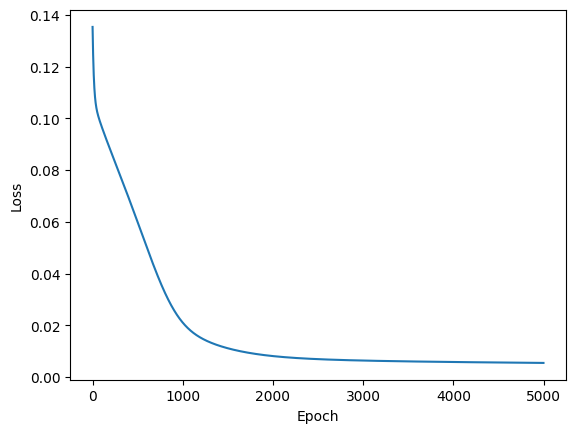

In [237]:
#plot loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_track, label ="loss")
plt.legend
plt.show()

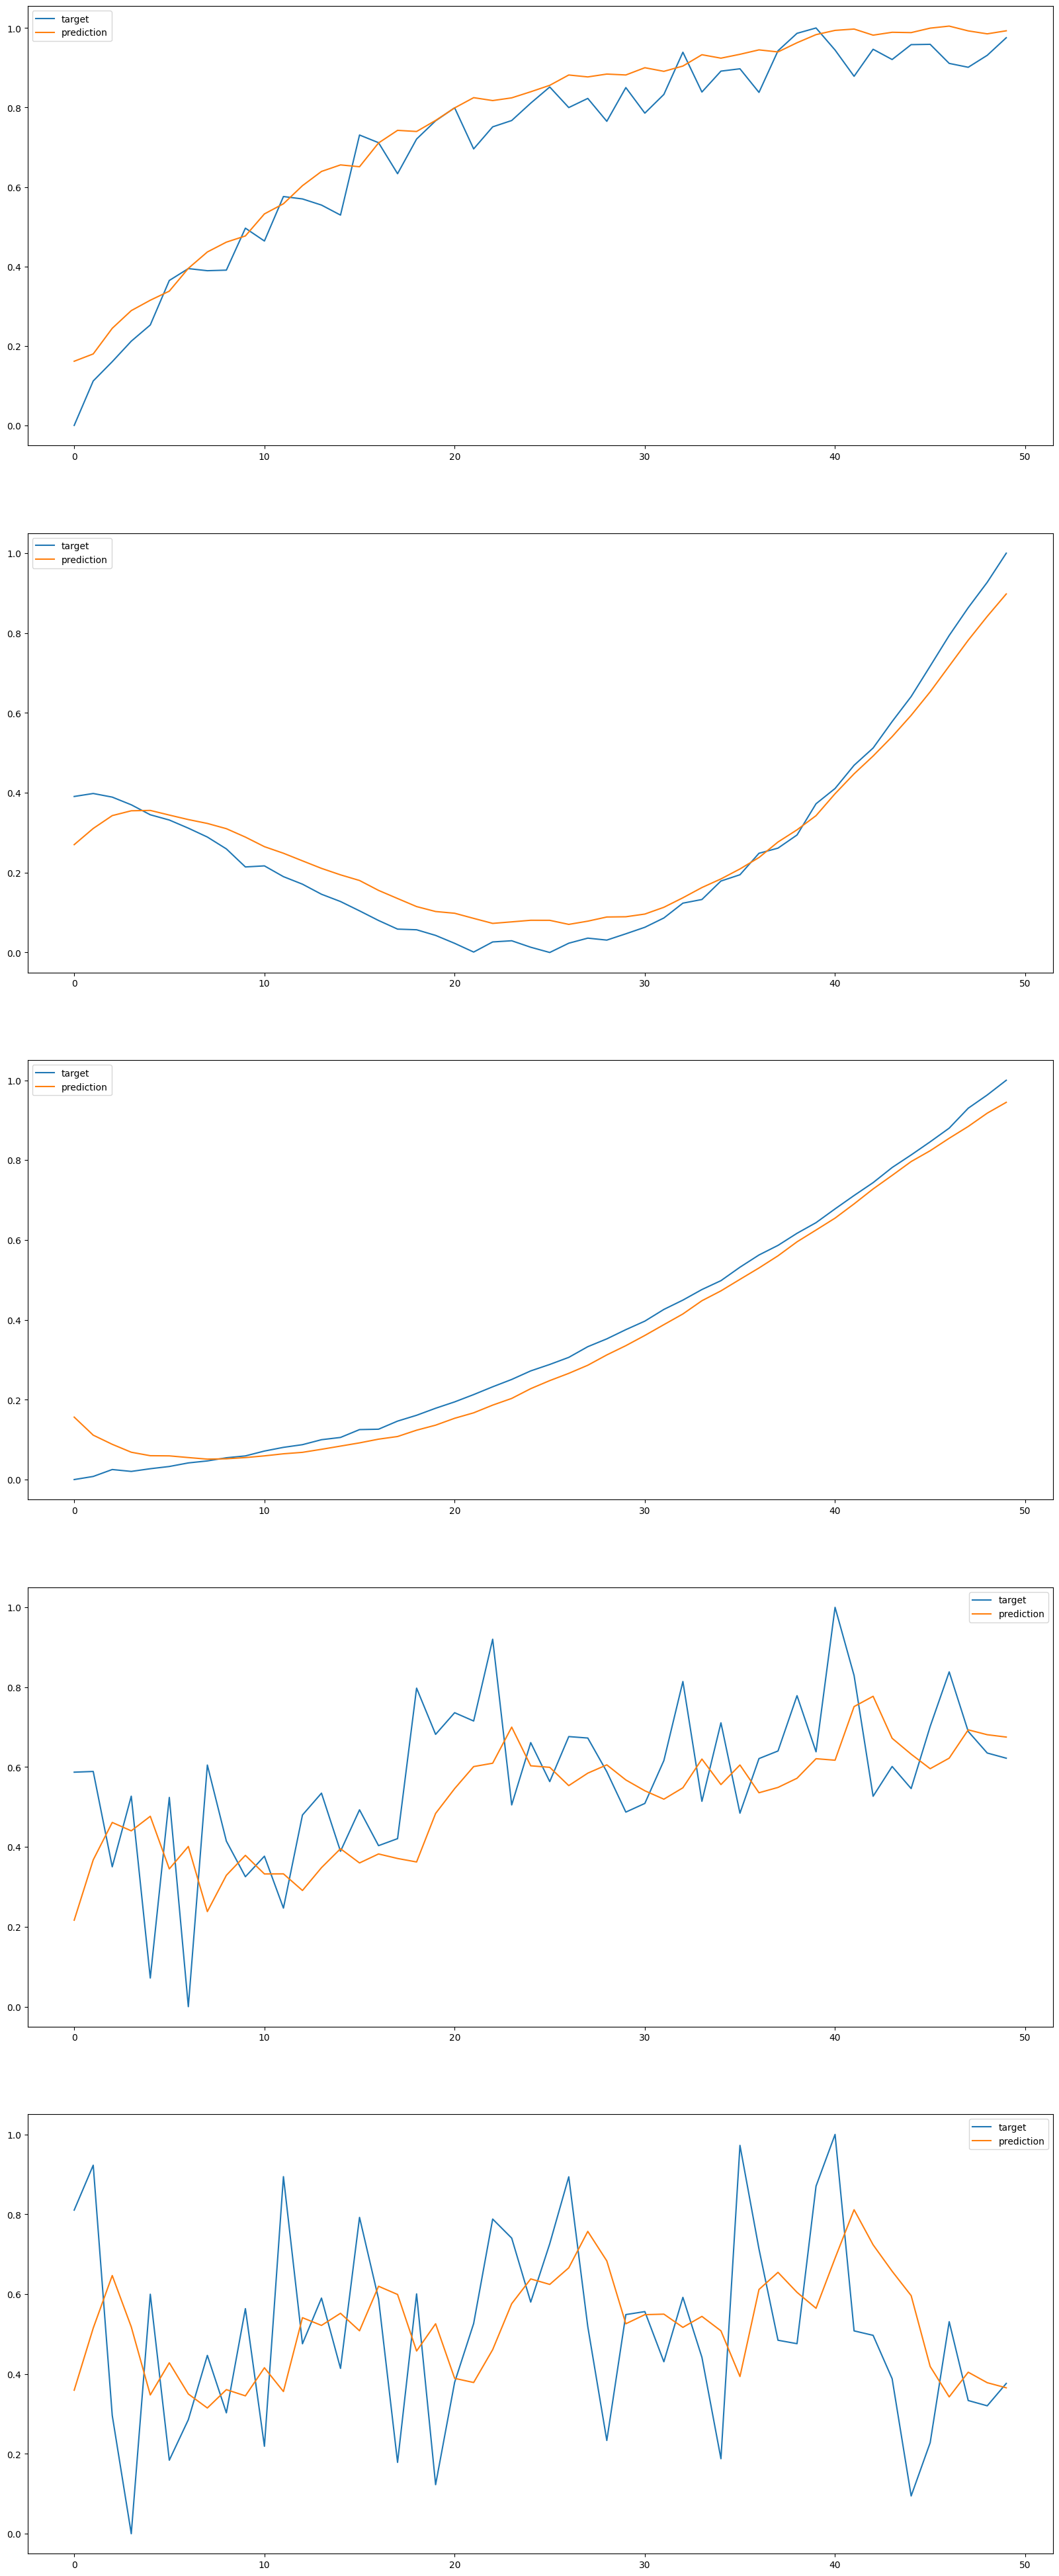

In [238]:
#Plot 4 random curves from training data and worst individual
n = 5
ex = randint(1,400, n-1)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(n-1):
    axs[k].plot(target_train[ex[k]].detach().numpy(), label= 'target')
    axs[k].plot(y_pred[ex[k]].detach().numpy(), label= 'prediction')
    axs[k].legend()
axs[n-1].plot(target_train[np.argmax(RMSE_list)].detach().numpy(), label= 'target')
axs[n-1].plot(y_pred[np.argmax(RMSE_list)].detach().numpy(), label= 'prediction')
axs[n-1].legend()

In [239]:
#RMSE on test data
y_pred = model(input_test)
#Results
RMSE_list = []
for k in range(len(y_pred)):
    RMSE_list.append(root_mean_squared_error(y_pred[k].detach().numpy(),target_train[k].detach().numpy()))
print("mean RMSE on test data: ", np.mean(RMSE_list))
print("Worst case :", np.max(RMSE_list), "for individual ", np.argmax(RMSE_list))

mean RMSE on test data:  0.28698194
Worst case : 0.75209934 for individual  98


torch.Size([100, 50, 1])
[(68, 0.031454403), (68, 0.031454403), (10, 0.029829353), (84, 0.042469718), (22, 0.029079935), (37, 0.12828931), (88, 0.086531386), (71, 0.13688137), (89, 0.025100779), (89, 0.025100779)]


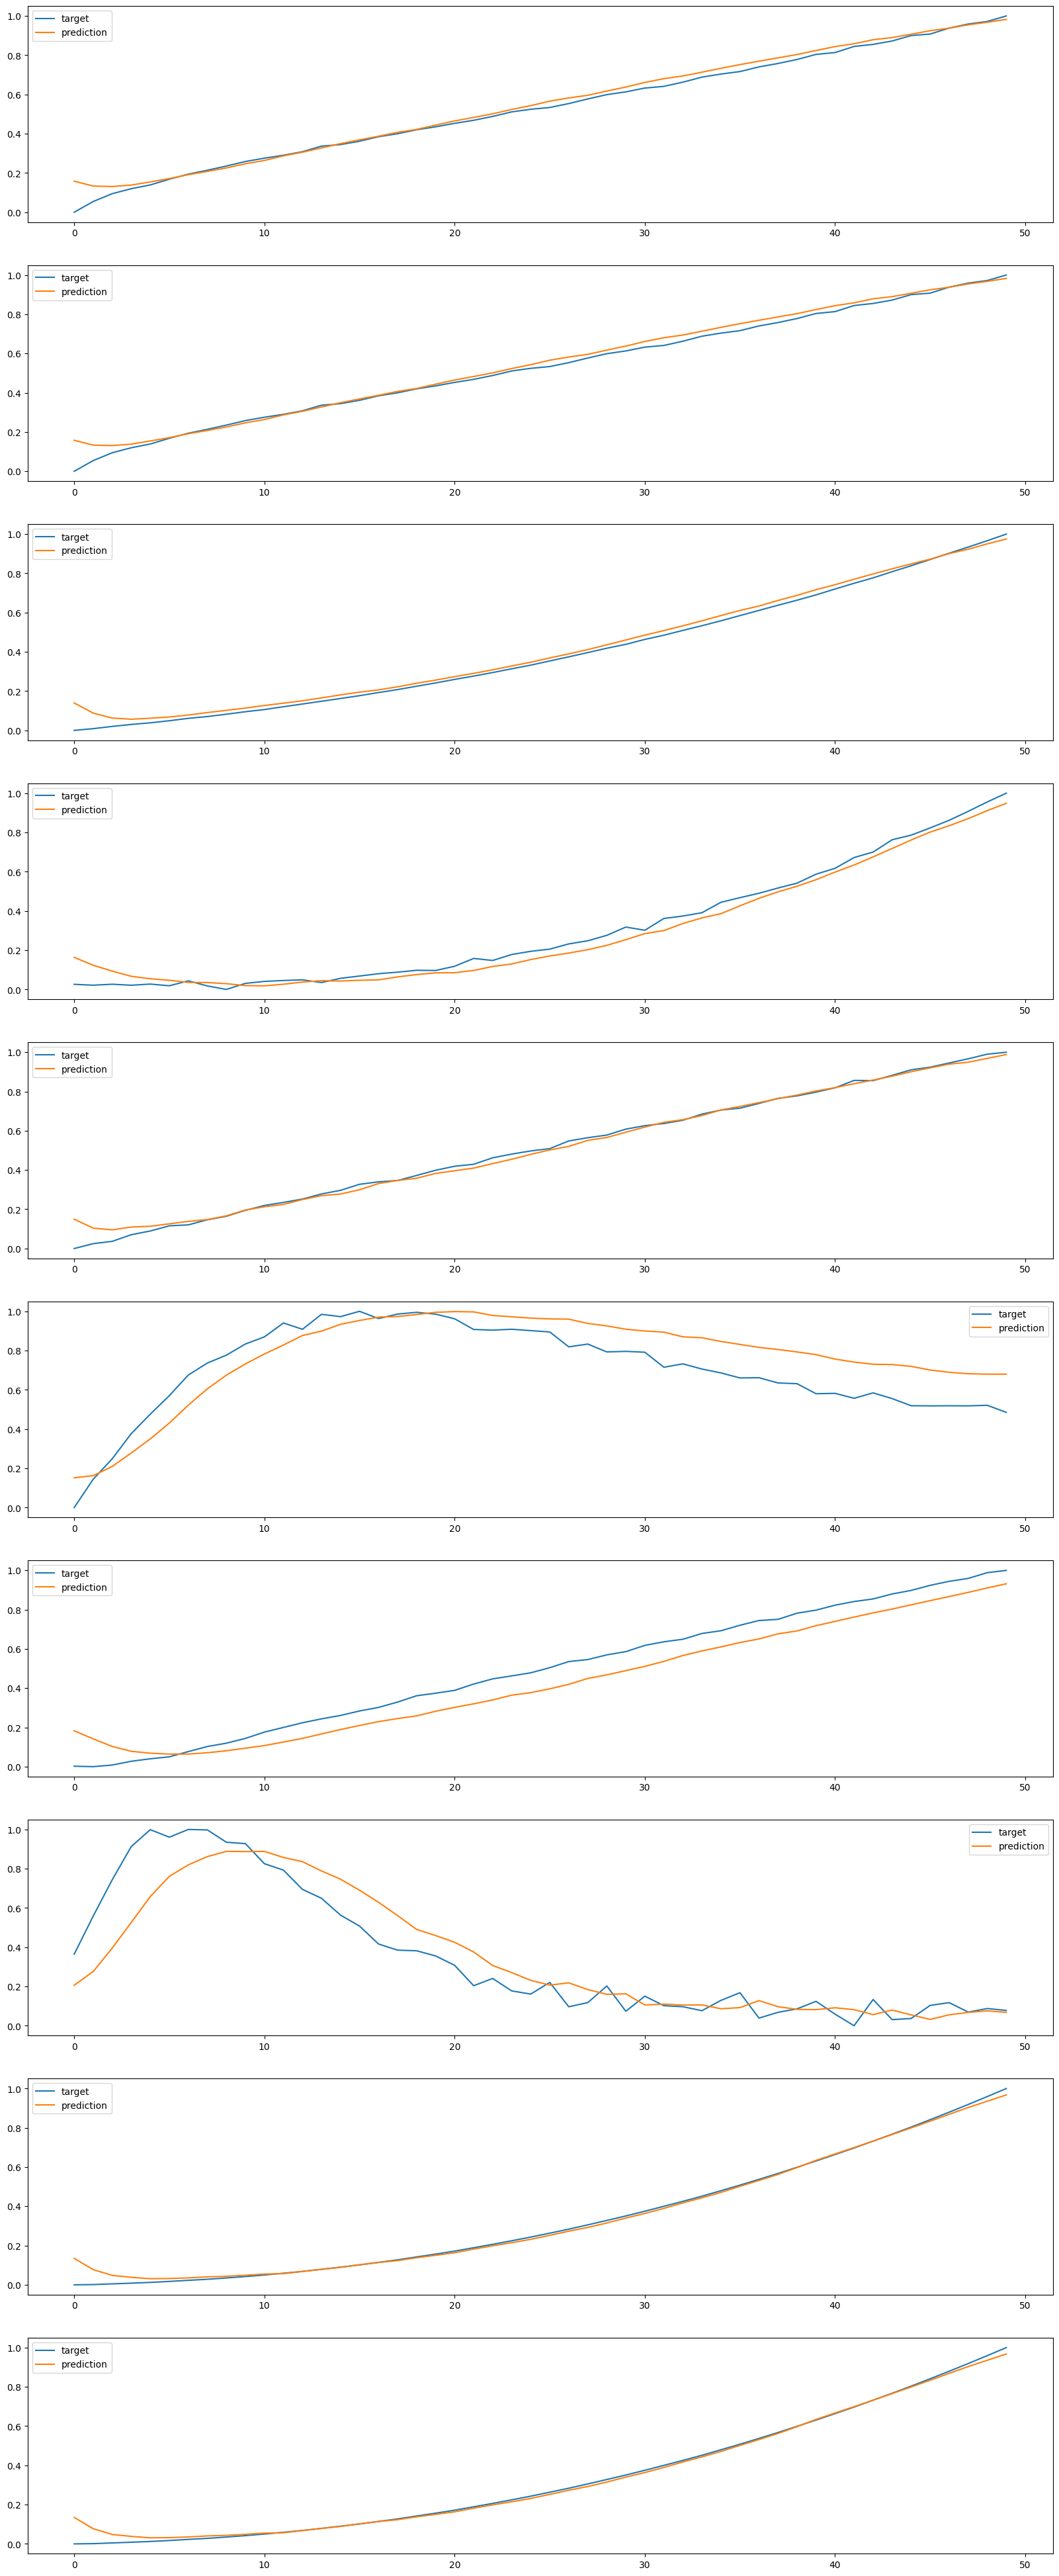

In [240]:
#Plot n curves from test data
n = 10
ex = randint(1,100, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
res = []
print(y_pred.shape)
for k in range(n):
    res.append((ex[k], root_mean_squared_error(target_test[ex[k]].detach().numpy(), y_pred[ex[k]].detach().numpy())))
    axs[k].plot(target_test[ex[k]].detach().numpy(), label= 'target')
    axs[k].plot(y_pred[ex[k]].detach().numpy(), label= 'prediction')
    axs[k].legend()

print(res) #res contient les RMSE

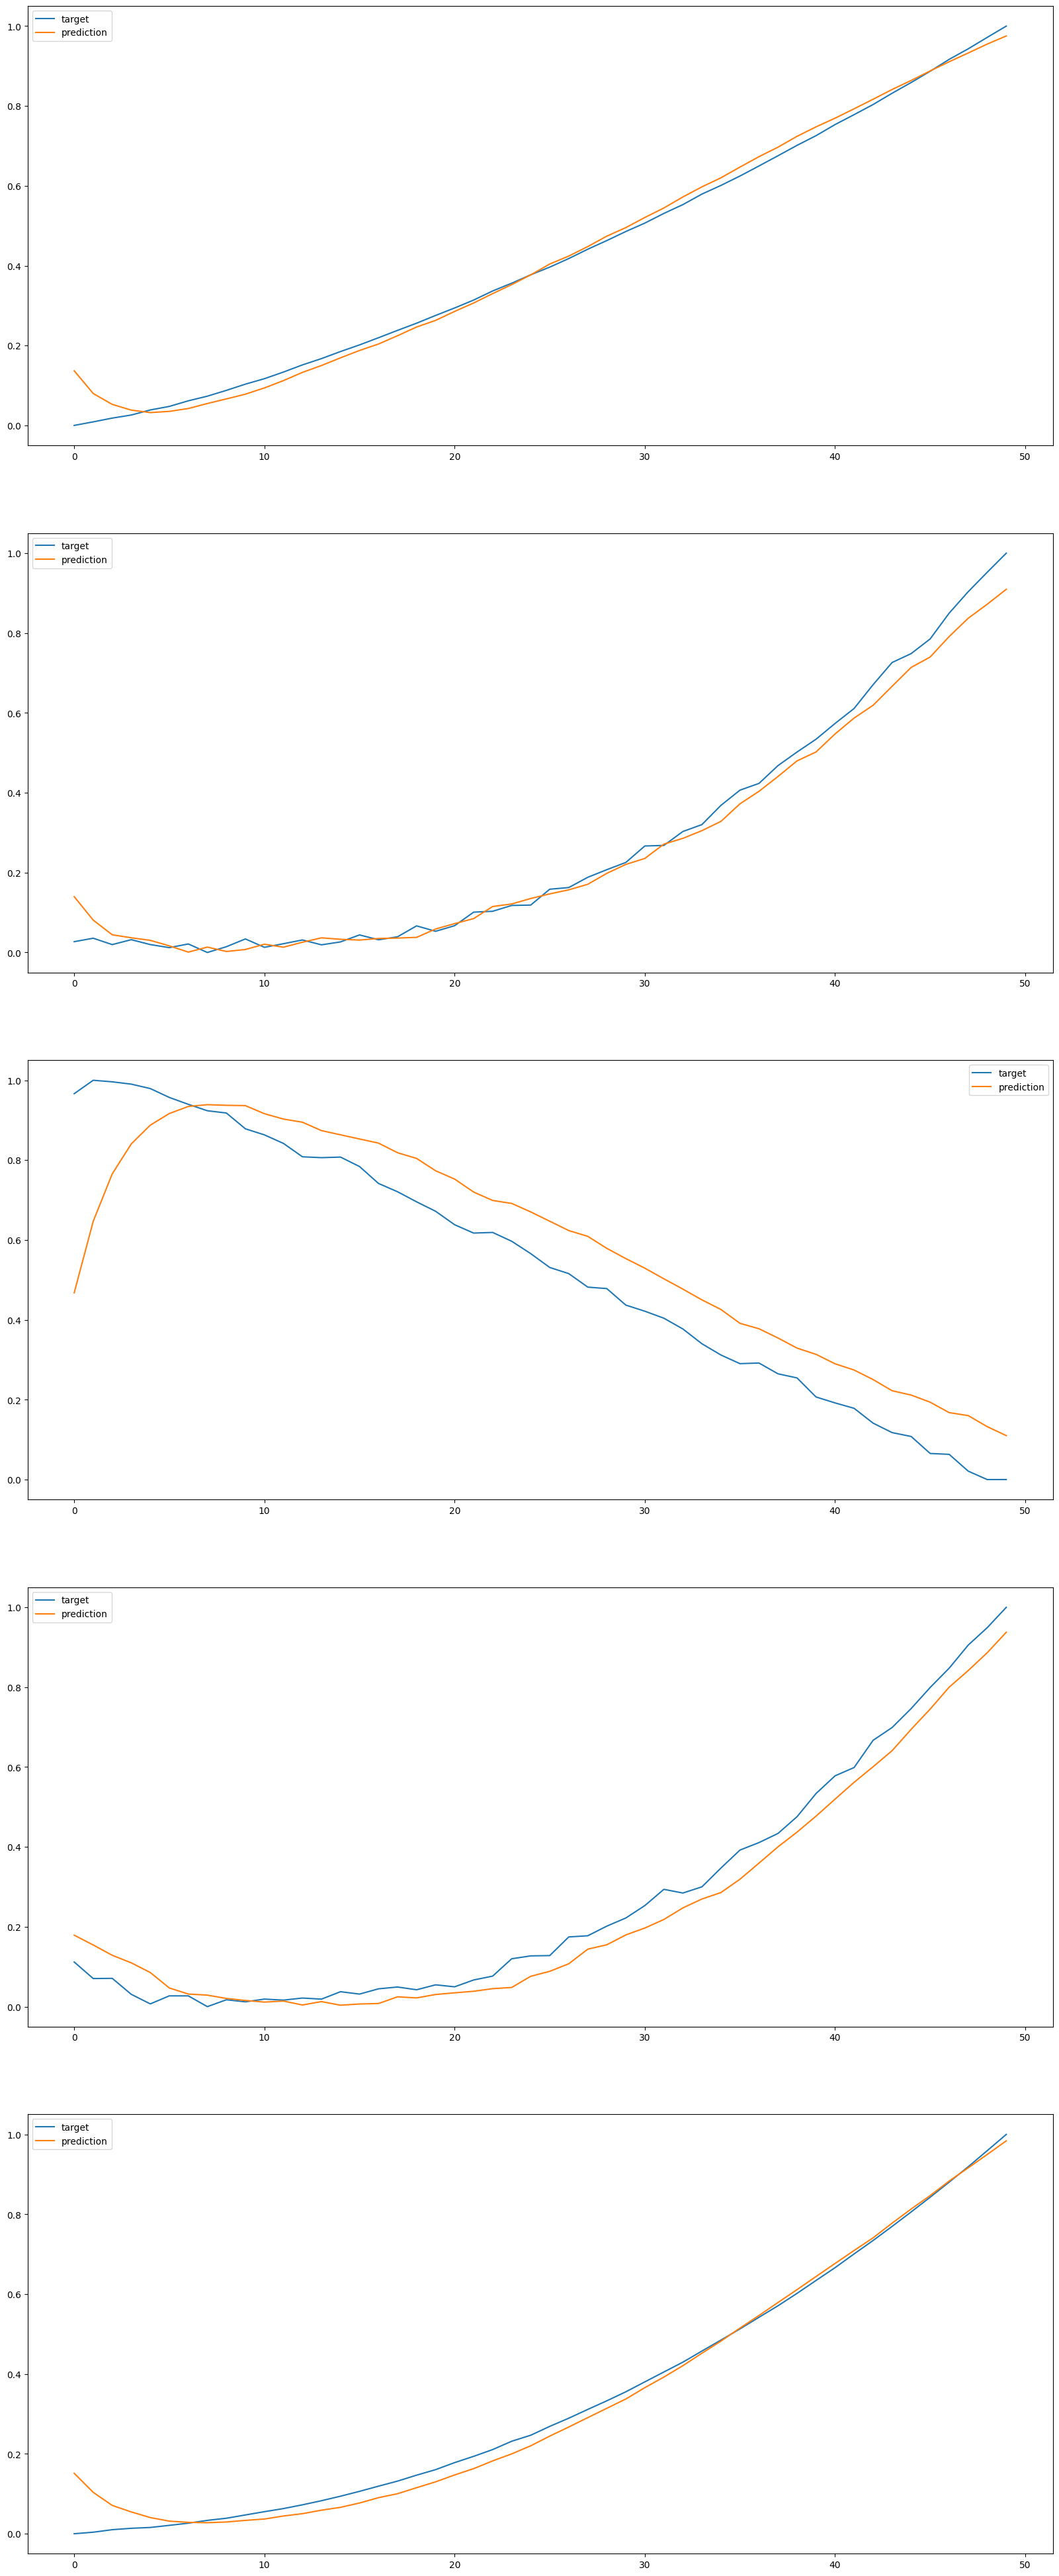

In [241]:
#plot n worst curves
indices = np.argpartition(RMSE_list, -5)[-5:]
n = 5
ex = randint(1,100, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(len(indices)):
    axs[k].plot(target_test[indices[k]].detach().numpy(), label= 'target')
    axs[k].plot(y_pred[indices[k]].detach().numpy(), label= 'prediction')
    axs[k].legend()

In [182]:
#hyperparamètres
lstm = LSTM(input_size = 9, hidden_size = 25, output_size=1)
criterion = torch.nn.MSELoss()
#SGD = Stochastic gradient descent, lr = learning rate
optimizer = torch.optim.SGD(lstm.parameters(), lr = 0.01)
epoch_lstm = 5000

In [183]:
#LSTM: training
loss_track = []
for k in range(epoch_lstm):
    y_pred = lstm(input=input_train)
    loss = criterion(y_pred, target_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_track.append(loss.item())

In [ ]:
#LSTM : Results on training
RMSE_list = []
for k in range(len(y_pred)):
    RMSE_list.append(root_mean_squared_error(y_pred[k].detach().numpy(),target_train[k].detach().numpy()))
print("mean RMSE on train data: ", np.mean(RMSE_list))
print("Worst case :", np.max(RMSE_list), "for individual ", np.argmax(RMSE_list))

In [ ]:
#plot loss lstm
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_track, label ="loss")
plt.legend
plt.show()

In [ ]:
#LSTM: RMSE on test data
y_pred = model(input_test)
#Results
RMSE_list = []
for k in range(len(y_pred)):
    RMSE_list.append(root_mean_squared_error(y_pred[k].detach().numpy(),target_train[k].detach().numpy()))
print("mean RMSE on test data: ", np.mean(RMSE_list))
print("Worst case :", np.max(RMSE_list), "for individual ", np.argmax(RMSE_list))

In [ ]:
#LSTM : plot 10 curves from test data
n = 10
ex = randint(1,100, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
res = []
for k in range(n):
    y_pred = lstm(input_test[ex[k]])
    res.append((ex[k], root_mean_squared_error(target_test[ex[k]].detach().numpy(), y_pred.detach().numpy())))
    axs[k].plot(target_test[ex[k]].detach().numpy(), label= 'target')
    axs[k].plot(y_pred.detach().numpy(), label= 'prediction')
    axs[k].legend()
print(res) #res contient les RMSE